# TODO

- [x] filter for weird routes (over land, non-smooth, etc.)
- [ ] Check dependency of typical best cost and typical runtime on hyperparameters

## Filtering for broken routes by length

Let's cut away routes which are more than twice as long as the seed route.

In [1]:
from pathlib import Path
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import shapely
from matplotlib import pyplot as plt

from ship_routing.app.routing import RoutingResult, RoutingLog
import msgpack
from tqdm.auto import tqdm

In [2]:
!ls -ltr results/

total 371968
-rw-r--r--  1 wrath  GEOMAR\Domänen-Benutzer    479046 Dec  6 12:50 results_testing_19429596.msgpack
-rw-r--r--  1 wrath  GEOMAR\Domänen-Benutzer  25901597 Dec  6 17:32 results_19430026.msgpack
-rw-r--r--  1 wrath  GEOMAR\Domänen-Benutzer  26612920 Dec  6 18:03 results_19430021.msgpack
-rw-r--r--  1 wrath  GEOMAR\Domänen-Benutzer  26726101 Dec  6 18:07 results_19430025.msgpack
-rw-r--r--  1 wrath  GEOMAR\Domänen-Benutzer  28136707 Dec  6 18:10 results_19430022.msgpack
-rw-r--r--  1 wrath  GEOMAR\Domänen-Benutzer  28039341 Dec  6 18:15 results_19430024.msgpack
-rw-r--r--  1 wrath  GEOMAR\Domänen-Benutzer  25645870 Dec  6 18:17 results_19430020.msgpack
-rw-r--r--  1 wrath  GEOMAR\Domänen-Benutzer  28891533 Dec  6 18:37 results_19430023.msgpack


In [3]:
data_files = sorted(Path("results/").glob("results_1*.msgpack"))
len(data_files)

7

In [4]:
def load_results(msgpack_file: str, nitems: int = None) -> dict[str, RoutingResult]:
    """Load all results from msgpack file.

    Parameters
    ----------
    msgpack_file : str
        Path to msgpack file containing serialized results.
    nitems: int (optional)
        Restrict to first nitems items.

    Returns
    -------
    dict[str, RoutingResult]
        Dictionary mapping result keys to RoutingResult objects.
    """
    with open(msgpack_file, "rb") as f:
        raw_results = msgpack.unpack(f, raw=False)

    return {
        key: RoutingResult.from_msgpack(value) for key, value in tqdm(list(raw_results.items())[:nitems])
    }

In [5]:
results = load_results(data_files[0], None)
for _df in data_files[1:]:
    results.update(load_results(_df, None))

  0%|          | 0/1989 [00:00<?, ?it/s]

IOStream.flush timed out


  0%|          | 0/1994 [00:00<?, ?it/s]

  0%|          | 0/1988 [00:00<?, ?it/s]

  0%|          | 0/1981 [00:00<?, ?it/s]

  0%|          | 0/1984 [00:00<?, ?it/s]

  0%|          | 0/1991 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [6]:
len(results)

13927

In [7]:
def remove_freak_results(routing_results_dict: dict = None):
    """There shold not be elite routes which are shorter than the original one."""
    return {
        k: v
        for k, v in tqdm(routing_results_dict.items())
        if not any([
            (
                (m.route.length_meters <= v.seed_member.route.length_meters)
                or (m.cost == 0)
                or (np.isinf(v.seed_member.cost))
            )
            for m in v.elite_population.members
        ])
    }

In [8]:
results = remove_freak_results(results)

  0%|          | 0/13927 [00:00<?, ?it/s]

In [9]:
print(len(results))

9923


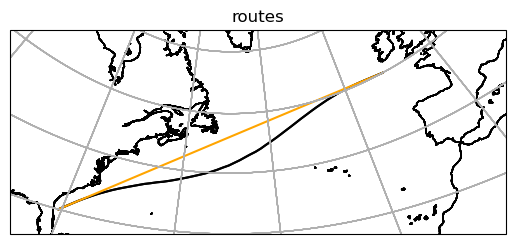

In [10]:
res_list = list(results.values())
ax = None
for _res in res_list[-16:]:
    ax = _res.plot_routes(ax=ax)

In [11]:
def get_journey_params_df(routing_results_dict: dict = None):
    def _fix_waypoints(dct):
        dct['lon_waypoints'] = str(dct['lon_waypoints'])
        dct['lat_waypoints'] = str(dct['lat_waypoints'])
        return dct
        
    df = pd.concat(
        [
            pd.DataFrame(
                _fix_waypoints(rr.logs.config["journey"]),
                index=[
                    f,
                ],
            )
            for f, rr in routing_results_dict.items()
        ]
    ).add_prefix("journey_")
    df = df.assign(
        journey_lon_waypoints=df["journey_lon_waypoints"].astype("category"),
        journey_lat_waypoints=df["journey_lat_waypoints"].astype("category"),
        journey_name=df["journey_name"].astype("category"),
        journey_time_start=df["journey_time_start"].astype("category"),
        journey_time_end=df["journey_time_end"].astype("category"),
    )
    df.index = df.index.rename("filename")
    return df

In [12]:
df_journey = get_journey_params_df(results)
df_journey

,journey_name,journey_lon_waypoints,journey_lat_waypoints,journey_time_start,journey_time_end,journey_speed_knots,journey_time_resolution_hours
filename,,,,,,,
result:2025-12-06T17-44-58.180_8709a686-711d-4bf0-a5df-1d5eaf040a8d,Atlantic_backward,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T16-52-02.421_55875002-ea2e-4cd2-9733-ab2634d0b5f8,Atlantic_forward,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T17-38-49.330_aea848e1-655d-4073-831b-7f264b7a86ab,Atlantic_backward,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T16-25-31.574_707a20bc-8f68-456f-a4e3-0215f0a9c5d2,Atlantic_forward,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T17-40-52.724_e82df9d7-dfe1-4f0b-ae8e-3fc370092951,Atlantic_backward,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00:00,2021-01-14T17:00:51,10.0,6.0
...,...,...,...,...,...,...,...
result:2025-12-06T17-32-07.603_1adadda5-c22d-4e5a-b5b6-a7cb81713b25,Atlantic_backward,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T17-00-52.978_e2ad78b7-b5c0-428d-bff4-6484100c5a5d,Atlantic_backward,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T17-00-43.079_078bd29b-f983-4976-a6b9-2c92a6df56b8,Atlantic_backward,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00:00,2021-01-14T17:00:51,10.0,6.0


In [13]:
def get_hyper_params_df(routing_results_dict: dict = None):
    df = pd.concat(
        [
            pd.DataFrame(
                rr.logs.config["hyper"],
                index=[
                    f,
                ],
            )
            for f, rr in routing_results_dict.items()
        ]
    ).add_prefix("hyper_")
    df = df.assign(
        hyper_crossover_strategy=df["hyper_crossover_strategy"].astype("category")
    )
    df.index = df.index.rename("filename")
    return df

In [14]:
df_params = pd.merge(
    get_hyper_params_df(results), 
    get_journey_params_df(results), 
    left_index=True, 
    right_index=True,
)
df_params

,hyper_population_size,hyper_random_seed,hyper_selection_acceptance_rate_warmup,hyper_mutation_width_fraction_warmup,hyper_mutation_displacement_fraction_warmup,hyper_generations,hyper_offspring_size,hyper_crossover_rounds,hyper_selection_quantile,hyper_selection_acceptance_rate,...,hyper_distance_increment,hyper_num_workers,hyper_executor_type,journey_name,journey_lon_waypoints,journey_lat_waypoints,journey_time_start,journey_time_end,journey_speed_knots,journey_time_resolution_hours
filename,,,,,,,,,,,,,,,,,,,,,
result:2025-12-06T17-44-58.180_8709a686-711d-4bf0-a5df-1d5eaf040a8d,128,1282251641,0.3,0.5,0.25,1,128,2,0.25,0.00,...,10000.0,8,process,Atlantic_backward,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T16-52-02.421_55875002-ea2e-4cd2-9733-ab2634d0b5f8,128,3410662920,0.3,0.9,0.10,4,128,1,0.25,0.25,...,10000.0,8,process,Atlantic_forward,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T17-38-49.330_aea848e1-655d-4073-831b-7f264b7a86ab,128,1190596617,0.3,0.9,0.10,1,128,2,0.10,0.25,...,10000.0,8,process,Atlantic_backward,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T16-25-31.574_707a20bc-8f68-456f-a4e3-0215f0a9c5d2,32,3938699705,0.3,0.5,0.10,1,32,0,0.10,0.00,...,10000.0,8,process,Atlantic_forward,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T17-40-52.724_e82df9d7-dfe1-4f0b-ae8e-3fc370092951,32,2518100264,0.3,0.5,0.10,4,32,2,0.10,0.00,...,10000.0,8,process,Atlantic_backward,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00:00,2021-01-14T17:00:51,10.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
result:2025-12-06T17-32-07.603_1adadda5-c22d-4e5a-b5b6-a7cb81713b25,128,4139208098,0.3,0.5,0.10,4,128,2,0.10,0.00,...,10000.0,8,process,Atlantic_backward,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T17-00-52.978_e2ad78b7-b5c0-428d-bff4-6484100c5a5d,32,4169640510,0.3,0.9,0.10,2,32,2,0.10,0.25,...,10000.0,8,process,Atlantic_backward,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-06T17-00-43.079_078bd29b-f983-4976-a6b9-2c92a6df56b8,32,2983846085,0.3,0.5,0.25,2,32,2,0.10,0.25,...,10000.0,8,process,Atlantic_backward,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00:00,2021-01-14T17:00:51,10.0,6.0


In [15]:
df_params.describe().T

,count,mean,std,min,25%,50%,75%,max
hyper_population_size,9923.0,7.937600e+01,4.799836e+01,32.0,3.200000e+01,3.200000e+01,1.280000e+02,1.280000e+02
hyper_random_seed,9923.0,2.148732e+09,1.235401e+09,1061148.0,1.092325e+09,2.138209e+09,3.215980e+09,4.294574e+09
hyper_selection_acceptance_rate_warmup,9923.0,3.000000e-01,0.000000e+00,0.3,3.000000e-01,3.000000e-01,3.000000e-01,3.000000e-01
hyper_mutation_width_fraction_warmup,9923.0,6.980853e-01,2.000009e-01,0.5,5.000000e-01,5.000000e-01,9.000000e-01,9.000000e-01
hyper_mutation_displacement_fraction_warmup,9923.0,1.742215e-01,7.499974e-02,0.1,1.000000e-01,1.000000e-01,2.500000e-01,2.500000e-01
hyper_generations,9923.0,2.315832e+00,1.241223e+00,1.0,1.000000e+00,2.000000e+00,4.000000e+00,4.000000e+00
hyper_offspring_size,9923.0,7.937600e+01,4.799836e+01,32.0,3.200000e+01,3.200000e+01,1.280000e+02,1.280000e+02
hyper_crossover_rounds,9923.0,9.967752e-01,8.131092e-01,0.0,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00
hyper_selection_quantile,9923.0,1.749320e-01,7.500375e-02,0.1,1.000000e-01,1.000000e-01,2.500000e-01,2.500000e-01
hyper_selection_acceptance_rate,9923.0,1.264990e-01,1.249973e-01,0.0,0.000000e+00,2.500000e-01,2.500000e-01,2.500000e-01


In [16]:
def get_runtime(routing_results_dict: dict = None):
    _records = []
    for f, rr in routing_results_dict.items():
        _records.extend(
            [
                {
                    "filename": f,
                    "runtime": rr.logs.to_dataframe().timestamp.max()
                    - rr.logs.to_dataframe().timestamp.min(),
                }
            ]
        )
    df = pd.DataFrame.from_records(_records).set_index("filename")
    df = df.assign(runtime_seconds=df.runtime.dt.total_seconds())
    return df

In [17]:
df_runtime = get_runtime(results)
df_runtime

,runtime,runtime_seconds
filename,,
result:2025-12-06T17-44-58.180_8709a686-711d-4bf0-a5df-1d5eaf040a8d,0 days 00:04:02,242.0
result:2025-12-06T16-52-02.421_55875002-ea2e-4cd2-9733-ab2634d0b5f8,0 days 00:06:35,395.0
result:2025-12-06T17-38-49.330_aea848e1-655d-4073-831b-7f264b7a86ab,0 days 00:04:14,254.0
result:2025-12-06T16-25-31.574_707a20bc-8f68-456f-a4e3-0215f0a9c5d2,0 days 00:01:21,81.0
result:2025-12-06T17-40-52.724_e82df9d7-dfe1-4f0b-ae8e-3fc370092951,0 days 00:02:37,157.0
...,...,...
result:2025-12-06T17-32-07.603_1adadda5-c22d-4e5a-b5b6-a7cb81713b25,0 days 00:09:32,572.0
result:2025-12-06T17-00-52.978_e2ad78b7-b5c0-428d-bff4-6484100c5a5d,0 days 00:01:26,86.0
result:2025-12-06T17-00-43.079_078bd29b-f983-4976-a6b9-2c92a6df56b8,0 days 00:01:17,77.0


/var/folders/w1/m9mm9h9167z_gcfzfffr0rgsh6j6kj/T/ipykernel_1240/2164293856.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_runtime.groupby([df_params.journey_name, df_params.journey_time_start]).runtime_seconds.describe()["min"].plot.barh()


<Axes: ylabel='journey_name,journey_time_start'>

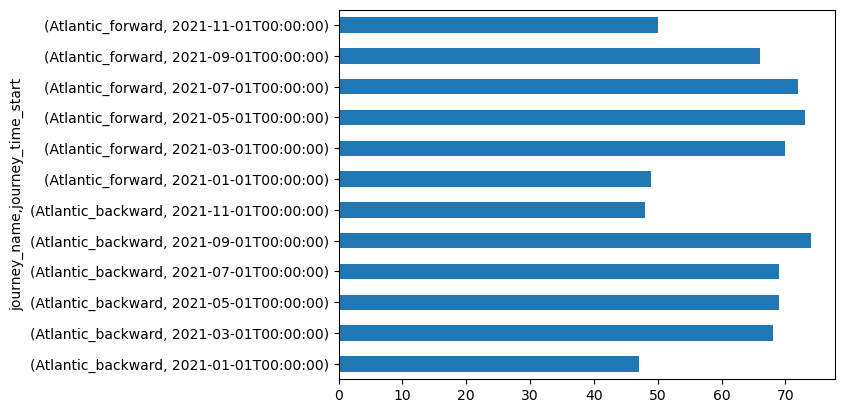

In [18]:
df_runtime.groupby([df_params.journey_name, df_params.journey_time_start]).runtime_seconds.describe()["min"].plot.barh()

In [19]:
def get_elite(routing_results_dict: dict = None):
    _records = []
    for f, rr in routing_results_dict.items():
        seed_member = rr.seed_member
        _records.extend(
            [
                {
                    "filename": f,
                    "n_elite": n,
                    "elite_length_meters": m.route.length_meters,
                    "elite_length_relative": m.route.length_meters / seed_member.route.length_meters,
                    "elite_cost_absolute": m.cost,
                    "elite_cost_relative": m.cost / seed_member.cost,
                }
                for n, m in enumerate(rr.elite_population.members)
            ]
        )
    return pd.DataFrame.from_records(_records).set_index("filename")

In [20]:
df_elite = get_elite(results)
df_elite

,n_elite,elite_length_meters,elite_length_relative,elite_cost_absolute,elite_cost_relative
filename,,,,,
result:2025-12-06T17-44-58.180_8709a686-711d-4bf0-a5df-1d5eaf040a8d,0,6.102691e+06,1.001534,9.154279e+12,0.948557
result:2025-12-06T17-44-58.180_8709a686-711d-4bf0-a5df-1d5eaf040a8d,1,6.096694e+06,1.000550,9.457689e+12,0.979995
result:2025-12-06T16-52-02.421_55875002-ea2e-4cd2-9733-ab2634d0b5f8,0,6.187051e+06,1.015379,9.483201e+12,0.888882
result:2025-12-06T16-52-02.421_55875002-ea2e-4cd2-9733-ab2634d0b5f8,1,6.187051e+06,1.015379,9.483201e+12,0.888882
result:2025-12-06T17-38-49.330_aea848e1-655d-4073-831b-7f264b7a86ab,0,6.101832e+06,1.001393,9.061711e+12,0.938965
...,...,...,...,...,...
result:2025-12-06T17-00-43.079_078bd29b-f983-4976-a6b9-2c92a6df56b8,1,6.117365e+06,1.003942,8.641144e+12,0.895386
result:2025-12-06T17-02-14.236_7bd1dfc2-bb9c-49b0-a5cd-ce2220f2bbf8,0,6.095817e+06,1.000406,9.542044e+12,0.988736
result:2025-12-06T17-02-14.236_7bd1dfc2-bb9c-49b0-a5cd-ce2220f2bbf8,1,6.095817e+06,1.000406,9.542044e+12,0.988736


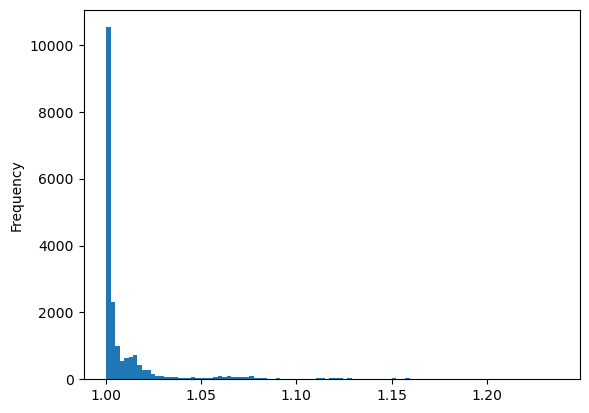

In [21]:
df_elite.elite_length_relative.plot.hist(bins=101);

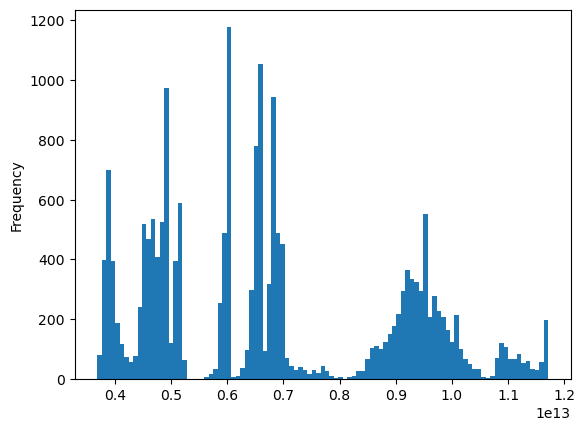

In [32]:
df_elite.elite_cost_absolute.plot.hist(bins=101);

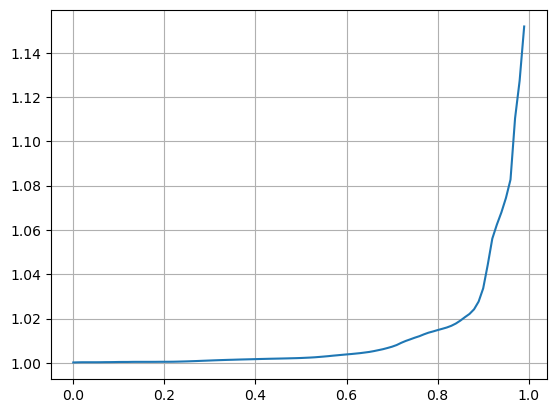

In [22]:
ax = df_elite.elite_length_relative.quantile(np.arange(0, 1, 0.01)).plot(logy=False, grid=True);

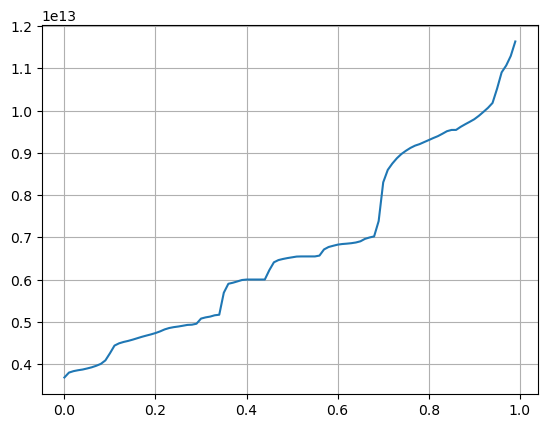

In [23]:
ax = df_elite.elite_cost_absolute.quantile(np.arange(0, 1, 0.01)).plot(logy=False, grid=True);

In [24]:
df_merged = (
    df_params
    .merge(df_elite, left_index=True, right_index=True, how="inner")
    .merge(df_runtime, left_index=True, right_index=True, how="inner")
)
df_merged

,hyper_population_size,hyper_random_seed,hyper_selection_acceptance_rate_warmup,hyper_mutation_width_fraction_warmup,hyper_mutation_displacement_fraction_warmup,hyper_generations,hyper_offspring_size,hyper_crossover_rounds,hyper_selection_quantile,hyper_selection_acceptance_rate,...,journey_time_end,journey_speed_knots,journey_time_resolution_hours,n_elite,elite_length_meters,elite_length_relative,elite_cost_absolute,elite_cost_relative,runtime,runtime_seconds
filename,,,,,,,,,,,,,,,,,,,,,
result:2025-12-06T17-44-58.180_8709a686-711d-4bf0-a5df-1d5eaf040a8d,128,1282251641,0.3,0.5,0.25,1,128,2,0.25,0.00,...,2021-01-14T17:00:51,10.0,6.0,0,6.102691e+06,1.001534,9.154279e+12,0.948557,0 days 00:04:02,242.0
result:2025-12-06T17-44-58.180_8709a686-711d-4bf0-a5df-1d5eaf040a8d,128,1282251641,0.3,0.5,0.25,1,128,2,0.25,0.00,...,2021-01-14T17:00:51,10.0,6.0,1,6.096694e+06,1.000550,9.457689e+12,0.979995,0 days 00:04:02,242.0
result:2025-12-06T16-52-02.421_55875002-ea2e-4cd2-9733-ab2634d0b5f8,128,3410662920,0.3,0.9,0.10,4,128,1,0.25,0.25,...,2021-01-14T17:00:51,10.0,6.0,0,6.187051e+06,1.015379,9.483201e+12,0.888882,0 days 00:06:35,395.0
result:2025-12-06T16-52-02.421_55875002-ea2e-4cd2-9733-ab2634d0b5f8,128,3410662920,0.3,0.9,0.10,4,128,1,0.25,0.25,...,2021-01-14T17:00:51,10.0,6.0,1,6.187051e+06,1.015379,9.483201e+12,0.888882,0 days 00:06:35,395.0
result:2025-12-06T17-38-49.330_aea848e1-655d-4073-831b-7f264b7a86ab,128,1190596617,0.3,0.9,0.10,1,128,2,0.10,0.25,...,2021-01-14T17:00:51,10.0,6.0,0,6.101832e+06,1.001393,9.061711e+12,0.938965,0 days 00:04:14,254.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
result:2025-12-06T17-00-43.079_078bd29b-f983-4976-a6b9-2c92a6df56b8,32,2983846085,0.3,0.5,0.25,2,32,2,0.10,0.25,...,2021-01-14T17:00:51,10.0,6.0,1,6.117365e+06,1.003942,8.641144e+12,0.895386,0 days 00:01:17,77.0
result:2025-12-06T17-02-14.236_7bd1dfc2-bb9c-49b0-a5cd-ce2220f2bbf8,32,3019516117,0.3,0.5,0.25,4,32,2,0.25,0.25,...,2021-01-14T17:00:51,10.0,6.0,0,6.095817e+06,1.000406,9.542044e+12,0.988736,0 days 00:02:48,168.0
result:2025-12-06T17-02-14.236_7bd1dfc2-bb9c-49b0-a5cd-ce2220f2bbf8,32,3019516117,0.3,0.5,0.25,4,32,2,0.25,0.25,...,2021-01-14T17:00:51,10.0,6.0,1,6.095817e+06,1.000406,9.542044e+12,0.988736,0 days 00:02:48,168.0


In [25]:
df_merged.columns

Index(['hyper_population_size', 'hyper_random_seed',
       'hyper_selection_acceptance_rate_warmup',
       'hyper_mutation_width_fraction_warmup',
       'hyper_mutation_displacement_fraction_warmup', 'hyper_generations',
       'hyper_offspring_size', 'hyper_crossover_rounds',
       'hyper_selection_quantile', 'hyper_selection_acceptance_rate',
       'hyper_mutation_width_fraction', 'hyper_mutation_displacement_fraction',
       'hyper_mutation_iterations', 'hyper_crossover_strategy',
       'hyper_ignore_hazards', 'hyper_num_elites', 'hyper_gd_iterations',
       'hyper_learning_rate_time', 'hyper_learning_rate_space',
       'hyper_time_increment', 'hyper_distance_increment', 'hyper_num_workers',
       'hyper_executor_type', 'journey_name', 'journey_lon_waypoints',
       'journey_lat_waypoints', 'journey_time_start', 'journey_time_end',
       'journey_speed_knots', 'journey_time_resolution_hours', 'n_elite',
       'elite_length_meters', 'elite_length_relative', 'elite_cost_a

In [26]:
df_analysis = (
  df_merged
  .groupby(level=0)  # group by filename
  .agg({
      'runtime_seconds': 'first',  # same for all rows
      **{col: 'first' for col in df_merged.columns if col.startswith('hyper_') or col.startswith('journey_')},
      **{col: 'first' for col in df_merged.columns if col.startswith('elite_')}
  })
)
df_analysis

,runtime_seconds,hyper_population_size,hyper_random_seed,hyper_selection_acceptance_rate_warmup,hyper_mutation_width_fraction_warmup,hyper_mutation_displacement_fraction_warmup,hyper_generations,hyper_offspring_size,hyper_crossover_rounds,hyper_selection_quantile,...,journey_lon_waypoints,journey_lat_waypoints,journey_time_start,journey_time_end,journey_speed_knots,journey_time_resolution_hours,elite_length_meters,elite_length_relative,elite_cost_absolute,elite_cost_relative
filename,,,,,,,,,,,,,,,,,,,,,
result:2025-12-06T16-23-04.753_b0a9a529-9e3c-4a77-805b-cbed8e7df70f,65.0,32,1585345806,0.3,0.5,0.10,1,32,2,0.10,...,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00:00,2021-01-14T17:00:51,10.0,6.0,6.227054e+06,1.021944,1.014021e+13,0.950466
result:2025-12-06T16-23-06.607_81cd854f-1217-4288-b8ec-7dc755403ab9,59.0,32,3974389947,0.3,0.5,0.10,2,32,0,0.25,...,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00:00,2021-01-14T17:00:51,10.0,6.0,6.164304e+06,1.011646,1.025072e+13,0.960823
result:2025-12-06T16-23-09.346_0511f9bb-1396-46ad-a782-8c001eb24fdf,62.0,32,1024999948,0.3,0.9,0.25,1,32,2,0.25,...,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00:00,2021-01-14T17:00:51,10.0,6.0,6.222459e+06,1.021190,9.675069e+12,0.906867
result:2025-12-06T16-23-09.405_babf6a7c-bfae-4e4f-8b19-e1c006238eb9,74.0,32,639545110,0.3,0.9,0.25,2,32,1,0.25,...,"[-80.5, -11.0]","[30.0, 50.0]",2021-11-01T00:00:00,2021-11-14T17:00:51,10.0,6.0,6.094704e+06,1.000224,1.006328e+13,0.983321
result:2025-12-06T16-23-10.037_2f6af01c-5435-4ab4-8a51-e7f30b356bf8,71.0,32,3019659374,0.3,0.5,0.10,1,32,0,0.10,...,"[-80.5, -11.0]","[30.0, 50.0]",2021-11-01T00:00:00,2021-11-14T17:00:51,10.0,6.0,6.100235e+06,1.001131,9.717802e+12,0.949563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
result:2025-12-06T18-24-49.977_dd781294-0e51-44ae-beef-4412fbaf5d64,208.0,128,2606845700,0.3,0.5,0.10,4,128,0,0.25,...,"[-11.0, -80.5]","[50.0, 30.0]",2021-07-01T00:00:00,2021-07-14T17:00:51,10.0,6.0,6.560284e+06,1.076631,4.642150e+12,0.923847
result:2025-12-06T18-25-08.549_42ec2c51-3f32-418c-b685-362f577c3a51,213.0,128,1387458783,0.3,0.5,0.25,1,128,2,0.10,...,"[-11.0, -80.5]","[50.0, 30.0]",2021-07-01T00:00:00,2021-07-14T17:00:51,10.0,6.0,6.224915e+06,1.021593,4.869461e+12,0.969085
result:2025-12-06T18-25-47.319_fab722d0-023b-4015-bdaf-199adc97a6af,417.0,128,1489076965,0.3,0.5,0.10,4,128,1,0.10,...,"[-11.0, -80.5]","[50.0, 30.0]",2021-07-01T00:00:00,2021-07-14T17:00:51,10.0,6.0,6.364671e+06,1.044529,4.681618e+12,0.931702


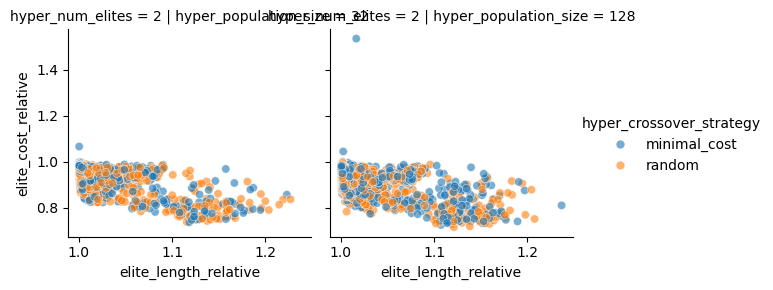

In [36]:
sns.relplot(
    data=df_analysis,
    x='elite_length_relative',
    y='elite_cost_relative',
    hue='hyper_crossover_strategy',
    col='hyper_population_size',
    row='hyper_num_elites',
    kind='scatter',
    alpha=0.6,
    height=3,
)

<Axes: xlabel='hyper_ignore_hazards', ylabel='hyper_population_size-hyper_generations'>

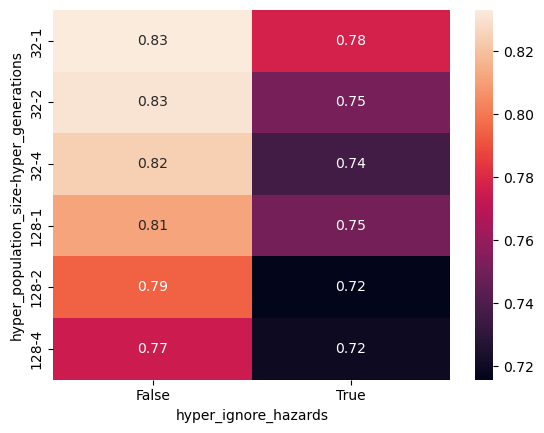

In [42]:
sns.heatmap(
    df_merged
    .groupby(['hyper_population_size', 'hyper_generations', 'hyper_ignore_hazards'])
    .elite_cost_relative
    .min()
    # .dt.total_seconds()
    .unstack(-1),
    annot=True
)

/var/folders/w1/m9mm9h9167z_gcfzfffr0rgsh6j6kj/T/ipykernel_1240/2794127089.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['journey_name', 'journey_time_start', 'hyper_population_size', 'hyper_generations'])


<Axes: xlabel='journey_time_start', ylabel='journey_name-hyper_population_size-hyper_generations'>

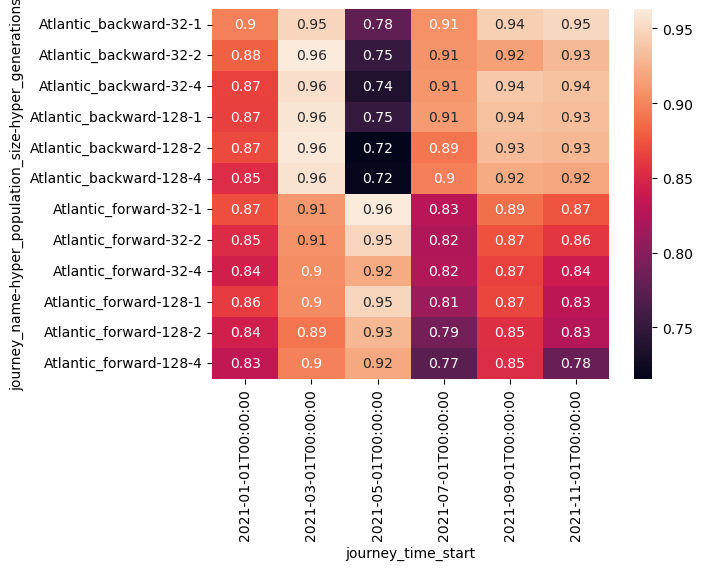

In [43]:
sns.heatmap(
    df_merged
    .groupby(['journey_name', 'journey_time_start', 'hyper_population_size', 'hyper_generations'])
    # .elite_cost_relative
    .elite_cost_relative
    # .quantile(np.linspace(0, 1, 11))
    .min()
    # .count()
    .unstack(1),
    annot=True,
    # cmap=sns.color_palette("viridis")
)

/var/folders/w1/m9mm9h9167z_gcfzfffr0rgsh6j6kj/T/ipykernel_1240/905402018.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['journey_name', 'journey_time_start', 'hyper_population_size', 'hyper_generations'])


<Axes: xlabel='journey_time_start', ylabel='journey_name-hyper_population_size-hyper_generations'>

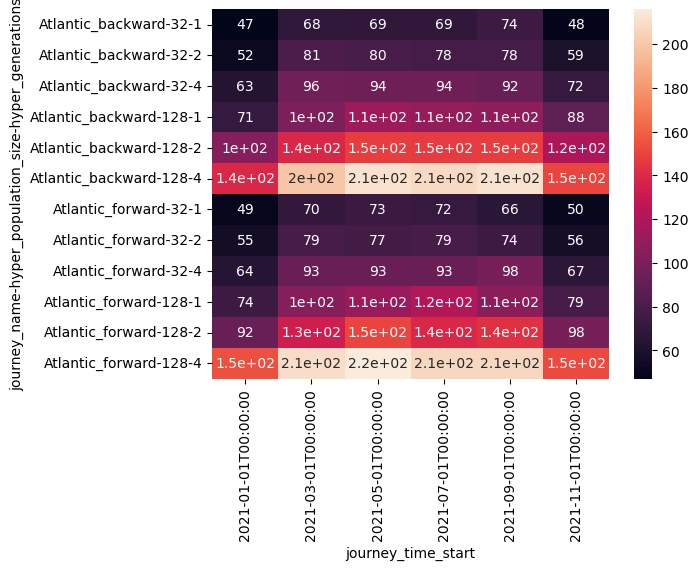

In [46]:
sns.heatmap(
    df_merged
    .groupby(['journey_name', 'journey_time_start', 'hyper_population_size', 'hyper_generations'])
    # .elite_cost_relative
    .runtime_seconds
    # .quantile(np.linspace(0, 1, 11))
    .min()
    # .count()
    .unstack(1),
    annot=True,
    # cmap=sns.color_palette("viridis")
)

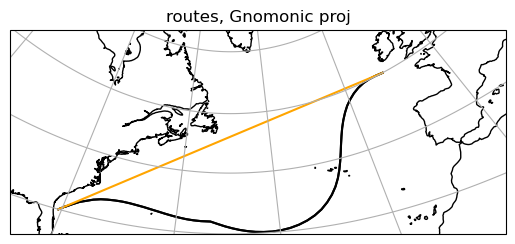

In [55]:
best = df_elite.index[df_elite.elite_length_relative.argmax()]
ax = results[best].plot_routes()